<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats2/blob/main/03_PyMC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. PyMC3入門 (2)
* 今回、PyMC3を解説するに当たっては、PyMC3の公式サイトを参考にした。
 * https://docs.pymc.io/notebooks/api_quickstart.html

## 3.0 準備

### 3.0.1 インストール

In [1]:
!pip install arviz==0.10

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 4.7MB 38.9MB/s 
     |████████████████████████████████| 768kB 45.5MB/s 
     |████████████████████████████████| 317kB 29.4MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


* PyMC3については、バージョン3.9以上。そうでないとできないことをするので。

In [2]:
!pip install pymc3==3.10

     |████████████████████████████████| 1.9MB 8.6MB/s 
     |████████████████████████████████| 2.8MB 29.5MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.0.11-cp37-none-any.whl size=2572023 sha256=78e82ffe4680ea33a9eecfa9eef7fc18bf1a19456278bd3cdda6085ff2d677ba
  Stored in directory: /root/.cache/pip/wheels/26/b2/77/4ee2bb9b1c1de7de771254a5e379d898273d8114237b0df686
Successfully built theano-pymc
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

SEED = [20100420, 20134234]

## 3.1 PyMC3によるMCMC

### 3.1.0 MCMC（マルコフ連鎖モンテカルロ）とは
* ベイズ的なモデリングにおいて、事後分布を推論する方法の一つ。
 * もう一つは変分推論(variational inference)。
* MCMCは、事後分布からのサンプルを通して、事後分布そのものを知ろうとする方法。
 * サンプルは、いわば「点」。
 * 「点」をいくら集めても「面」にはならない。
 * しかし、「点」をたくさん集めることで「面」の全体像を知ろうとするのが、MCMC。
* モデルが複雑になるほど、事後分布$p(\theta|X)$からのサンプリングは、難しくなっていく。
 * 比較的シンプルなモデルについては、良いサンプリングができる（例：LDAのcollapsed Gibbs sampling）。
* この授業では、MCMCを実際に使う方法だけを説明する。理屈は説明しない。
 * 事後分布からのサンプリングは、一般にはとても難しい作業。

### 3.1.1 PyMC3における確率モデルの定義

* PyMC3では、モデルを定義したら、関数`pm.sample()`を使えば、とりあえずは事後分布からのサンプルを得ることができる。

* 数値データがたくさんある。標準偏差は1らしい。平均は0に近いが、0からずれているかもしれない。
* ベイズ的なモデリングによって、平均がいくらの可能性がどのくらい、という、事後分布を得たい。
 * 平均の一個の推定値（最尤推定やMAP推定の場合）ではなく、平均の分布を知りたい。
* そこで、下記のモデルを使う。
$$ \mu \sim N(0, 1) $$
$$ x \sim N(\mu, 1) $$
* このモデルをPyMC3で書くと、次のようになる。

In [4]:
model = pm.Model()

with model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

### 3.1.2 PyMC3によるMCMCの実行

* `mu`が従う事後分布からサンプルを得るには、以下のようにすればよい。
* `tune`は、最初の何個のサンプルを捨てるかを指定する引数。
 * MCMCで得られるサンプルは、最初のほうのものは、通常、捨てる。

In [5]:
with model:
    idata = pm.sample(2000, tune=1500, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu]


Sampling 2 chains for 1_500 tune and 2_000 draw iterations (3_000 + 4_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8794898847895936, but should be close to 0.8. Try to increase the number of tuning steps.


* chainとは、サンプルの一つの系列のこと。
* MCMCによるサンプリングでは、直前のサンプルを少し変化させることで、次のサンプルを求める。
 * 前回説明したとおり、この変化のさせ方が賢いので、ちゃんと事後分布からのサンプルになる。
* ということは、サンプルは、初期値から始まって、一筋の系列をなしている。この系列をchainと呼ぶ。
* chainが一つだけだと心もとないので、普通は、複数のchainを走らせる。
* PyMC3のデフォルトの設定では、chainの数は、利用可能なコア数にしたがって自動的に決められる。

* 上のコードを実行すると、`idata`にサンプリング結果が保存されている。
* `idata.posterior`によって事後分布の情報にアクセスできる。

In [6]:
idata.posterior.dims

Frozen(SortedKeysDict({'chain': 2, 'draw': 2000}))

* サンプリングに使うcoreの数、生成するchainの数を指定する場合は、以下のようにする。
 * coresがコア数、chainsがchainの数。

In [7]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=1, observed=np.random.randn(100))

    idata = pm.sample(cores=4, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


* NUTS(No-U-Turn-Sampler)は、PyMC3においてデフォルトで使われるサンプラー。
 * HMCの改良版。詳細は割愛。 https://arxiv.org/abs/1111.4246

* chainは4本あり、それぞれ1000のサンプルから成っている。

In [8]:
idata.posterior["mu"].shape

(4, 1000)

* 特定のchainだけ選ぶ方法は以下の通り。

In [9]:
idata.posterior["mu"].sel(chain=0).shape

(1000,)

* 特定のchainの、最初の10個のサンプルだけ見てみる。

In [10]:
idata.posterior["mu"].sel(chain=1)[:10]

<xarray.DataArray 'mu' (draw: 10)>
array([ 0.24722012,  0.00339797, -0.10289555,  0.01754837,  0.12263788,
        0.1113351 ,  0.05991033,  0.05991033,  0.09517269,  0.01454801])
Coordinates:
    chain    int64 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

* chainの中身のデータ型はxarrayの配列。
 * NumPyの配列とは違う。

In [11]:
type(idata.posterior["mu"])

xarray.core.dataarray.DataArray

* `.data`でndarrayへ変換できる。

In [12]:
type(idata.posterior["mu"].data)

numpy.ndarray

In [13]:
idata.posterior["mu"].data.shape

(4, 1000)

* サンプルのヒストグラムを描くと、事後分布の大体の形が分かる。

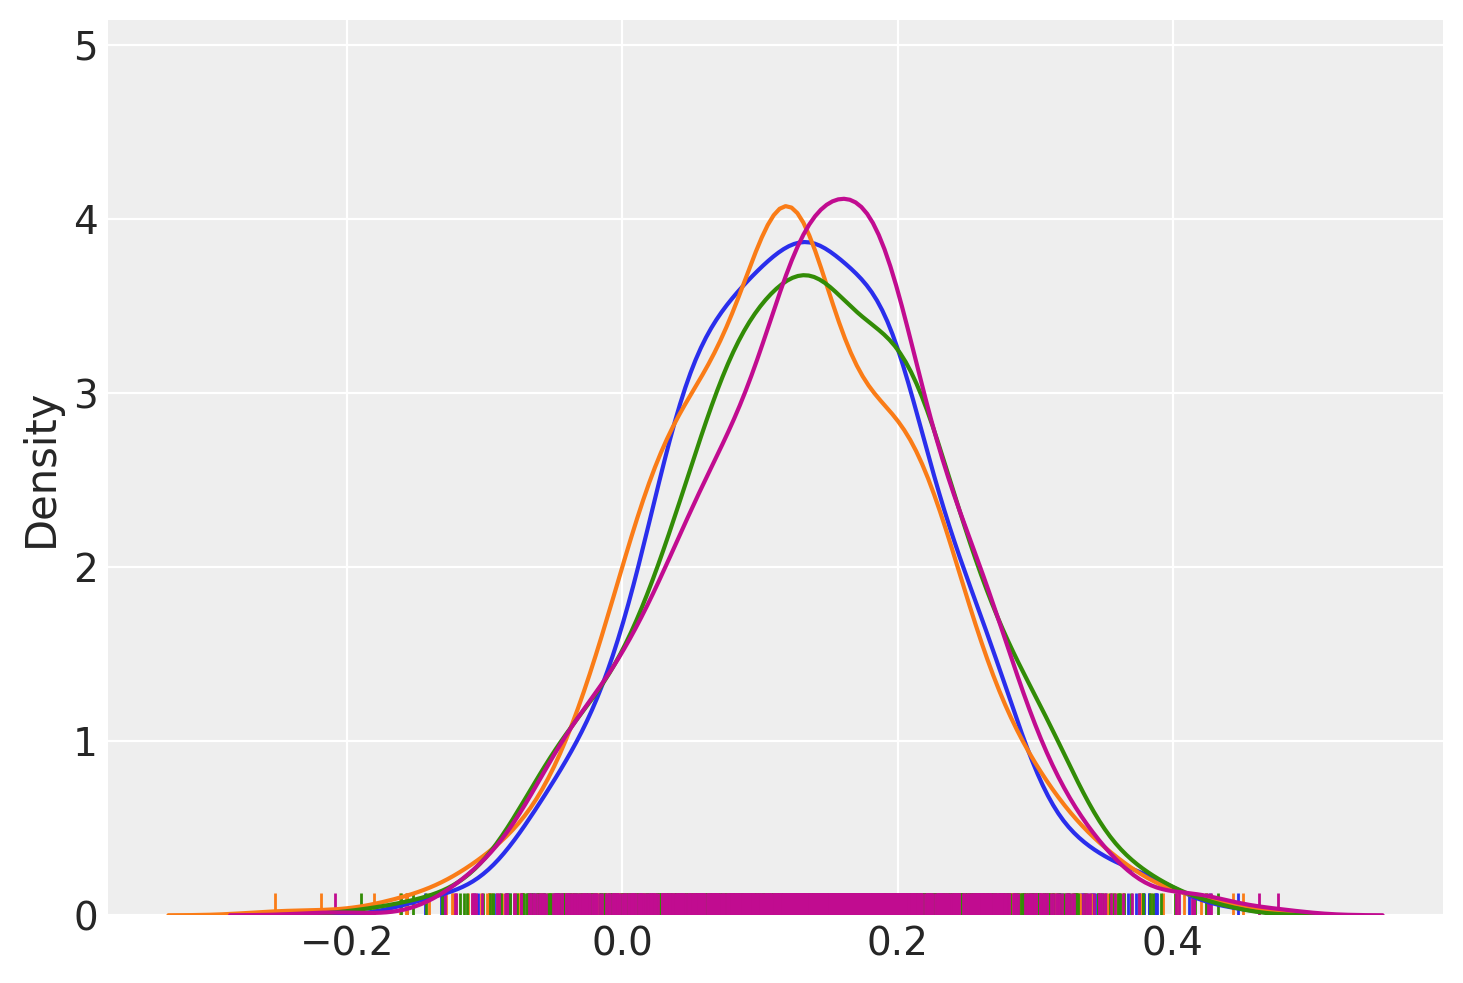

In [14]:
import seaborn as sns

for i in range(idata.posterior["mu"].data.shape[0]):
    sns.distplot(idata.posterior["mu"].data[i], rug=True, hist=False)

* さて、chainが４本からなるこのサンプルは、うまく事後分布を表しているのだろうか？
 * 以下、サンプルの分析手法を紹介する。

## 3.2 PyMC3で使えるサンプリング手法

* PyMC3のドキュメントには、以下のように書いてある。



> "For almost all continuous models, ``NUTS`` should be preferred."



* ``NUTS``では良いサンプルが得られない場合、``Metropolis``を使う人が多いが、これは良くない選択だ、とも書いてある。
* ``NUTS``でうまくいかない時は、初期値を変えるか、変数変換をするのが良い。
* Metropolis法では、effective sample sizeが小さくなってしまうことが多い。
 * つまり、$x^{new}$が新しい値に更新されないことが多い。

* PyMC3で実装されているサンプラーの一覧。

In [15]:
list(filter(lambda x: x[0].isupper(), dir(pm.step_methods)))

['BinaryGibbsMetropolis',
 'BinaryMetropolis',
 'CategoricalGibbsMetropolis',
 'CauchyProposal',
 'CompoundStep',
 'DEMetropolis',
 'DEMetropolisZ',
 'DEMetropolisZMLDA',
 'ElemwiseCategorical',
 'EllipticalSlice',
 'HamiltonianMC',
 'LaplaceProposal',
 'MLDA',
 'Metropolis',
 'MetropolisMLDA',
 'MultivariateNormalProposal',
 'NUTS',
 'NormalProposal',
 'PGBART',
 'PoissonProposal',
 'RecursiveDAProposal',
 'Slice',
 'UniformProposal']

## 3.2 サンプリング結果の分析
 * https://docs.pymc.io/notebooks/sampler-stats.html
 * https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html 

* MCMCを使うときには、サンプルが良いサンプルか悪いサンプルかを、気にしないといけない。
* 例えば、chainが事後分布の定義域のごく狭い範囲しか踏査していないかもしれない。
* あるいは、モード（分布の山）をちゃんと捉えていないかもしれない。

### 3.2.1 ヒストグラム


* 例題として、以下のモデルを考える。
$$\begin{align}
\mu & \sim N(0, 1) \\
\sigma & \sim \text{HalfNormal}(1) \\
x & \sim N(\mu, \sigma)
\end{align}$$
 * half-normal分布は、正規分布に従う確率変数の絶対値が従う分布。
 

* デフォルトのNUTS以外のサンプラーを試してみる。
* 平均パラメータと標準偏差パラメータとで、サンプリング手法を変えてみる。
 * 平均パラメータはメトロポリス法でサンプリングする。
 * 標準偏差パラメータのサンプリングは[スライスサンプリング](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%A9%E3%82%A4%E3%82%B9%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AA%E3%83%B3%E3%82%B0)で実現する。

* 乱数のシードを設定する場合は、chainの数だけシードを用意する。
* coresだけを設定した場合、chainの数はcore数に設定される。

In [16]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step1 = pm.Metropolis(vars=[mu])
    step2 = pm.Slice(vars=[sd])
    idata = pm.sample(10000, step=[step1, step2], cores=len(SEED), return_inferencedata=True, random_seed=SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Slice: [sd]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


* arvizでサンプルを可視化する。
 * デフォルトではkernel density estimates。ヒストグラムも選べる。
 * 全サンプルのプロットも右半分に描かれる。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d589f8a90>,
      dtype=object)

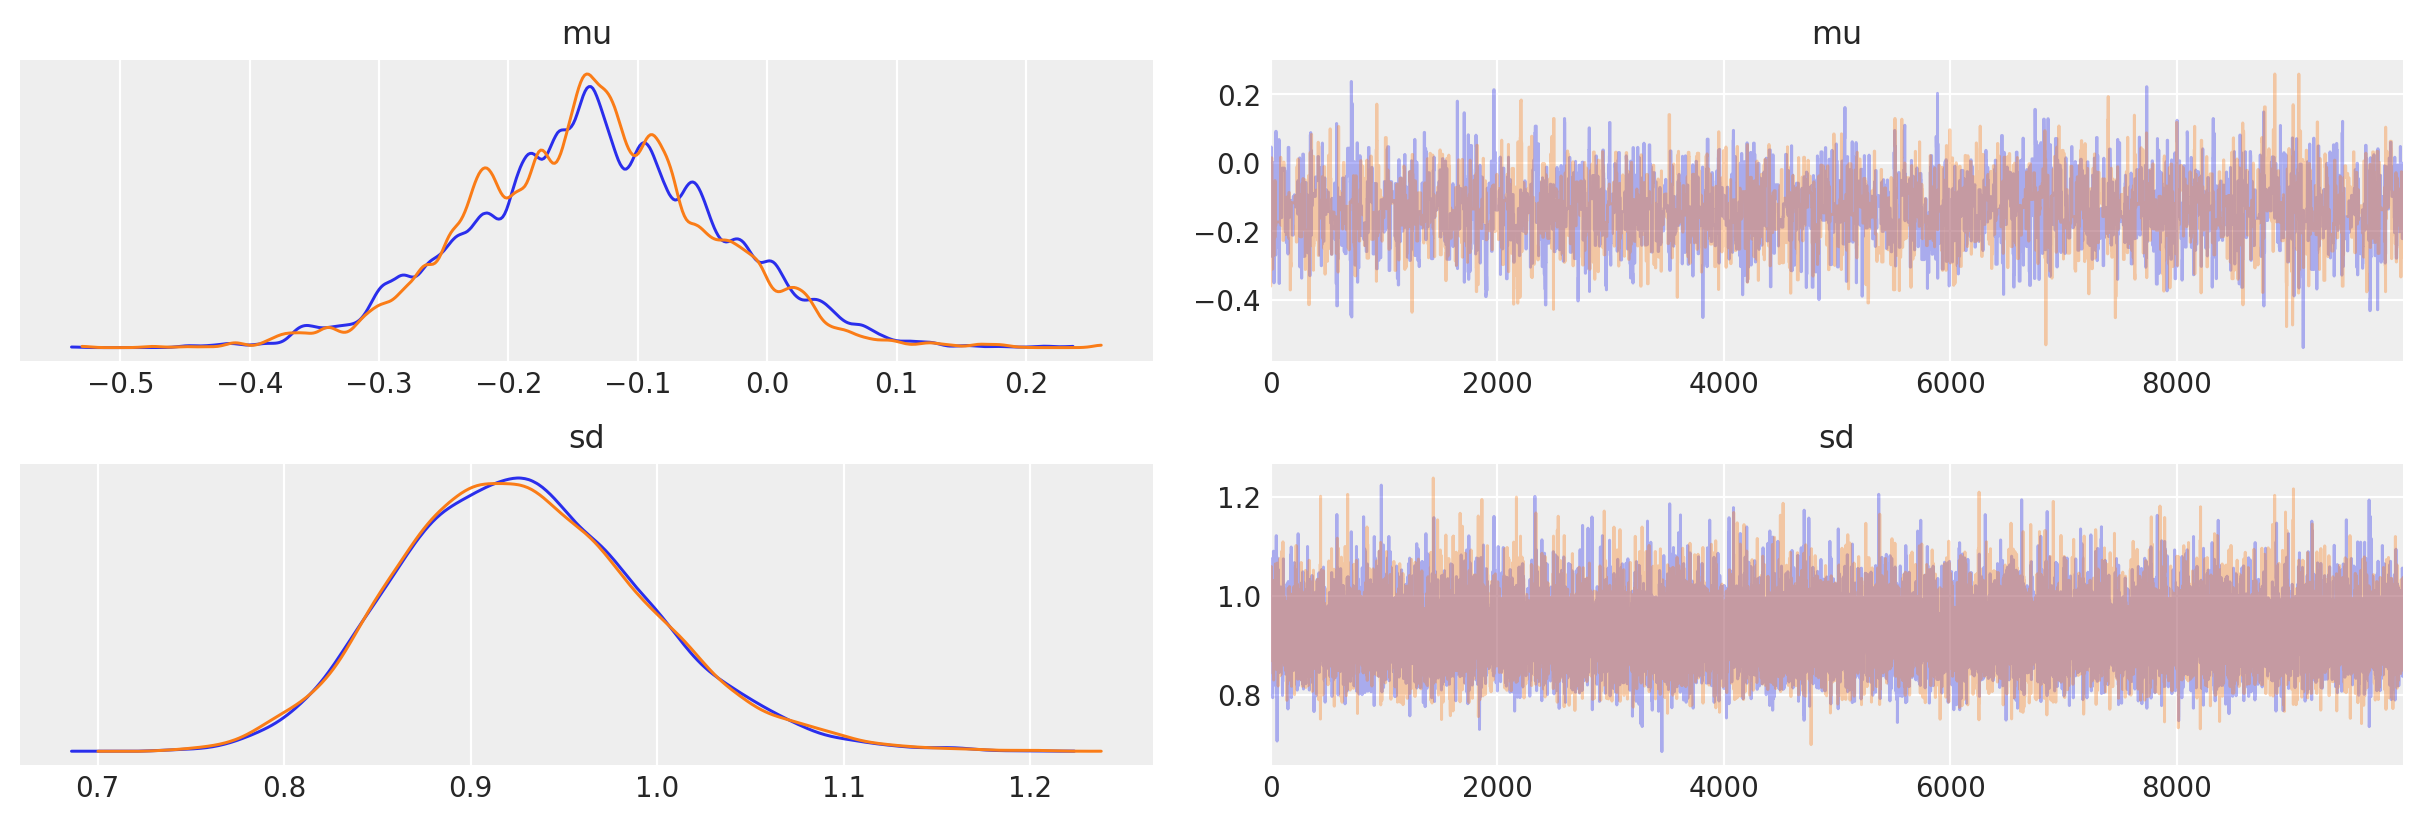

In [17]:
az.plot_trace(idata)

 * muの分布のほうだけ、やや凸凹している。

### 3.2.2 Gelman-Rubin統計量
* 定量的にサンプルの良し悪しを分析できる。
* R-hatと呼ばれる値が1に近いほど、連鎖の分布がより収束している。
 * http://www.omori.e.u-tokyo.ac.jp/MCMC/mcmc.pdf の6.2.2を参照。
* HDI (Highest density interval) については下記を参照。
 * https://www.sciencedirect.com/topics/mathematics/highest-density-interval 

In [18]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-0.136,0.093,-0.304,0.041,0.002,0.001,2820.0,2802.0,2793.0,3092.0,1.0
sd,0.929,0.066,0.806,1.053,0.001,0.000,17238.0,17008.0,17517.0,14572.0,1.0


 ### 3.2.3 HDI (Highest density interval)
* forest plot
  * デフォルトではHDI=94.0%の区間を図示する。
  * r_hat=TrueでR-hat統計量も図示する。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d53a7e2d0>,
      dtype=object)

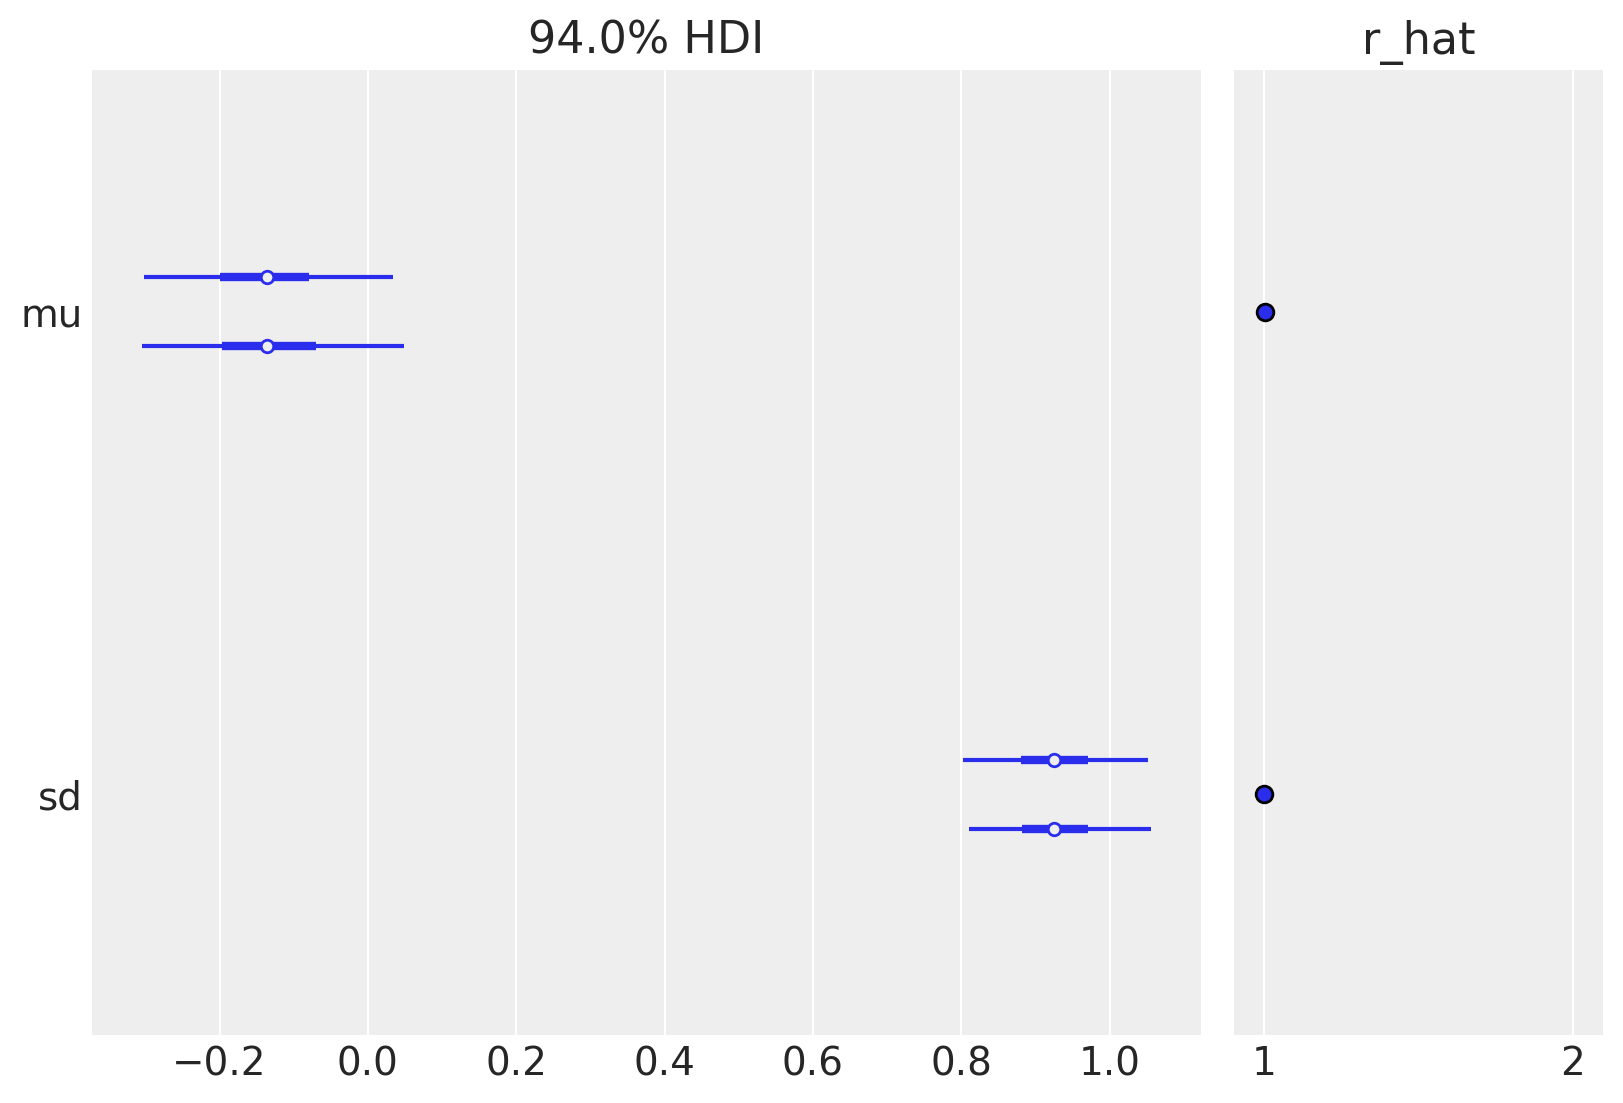

In [19]:
az.plot_forest(idata, r_hat=True)

* ridge plot

Text(0.5, 1.0, 'Estimated mu and sd')

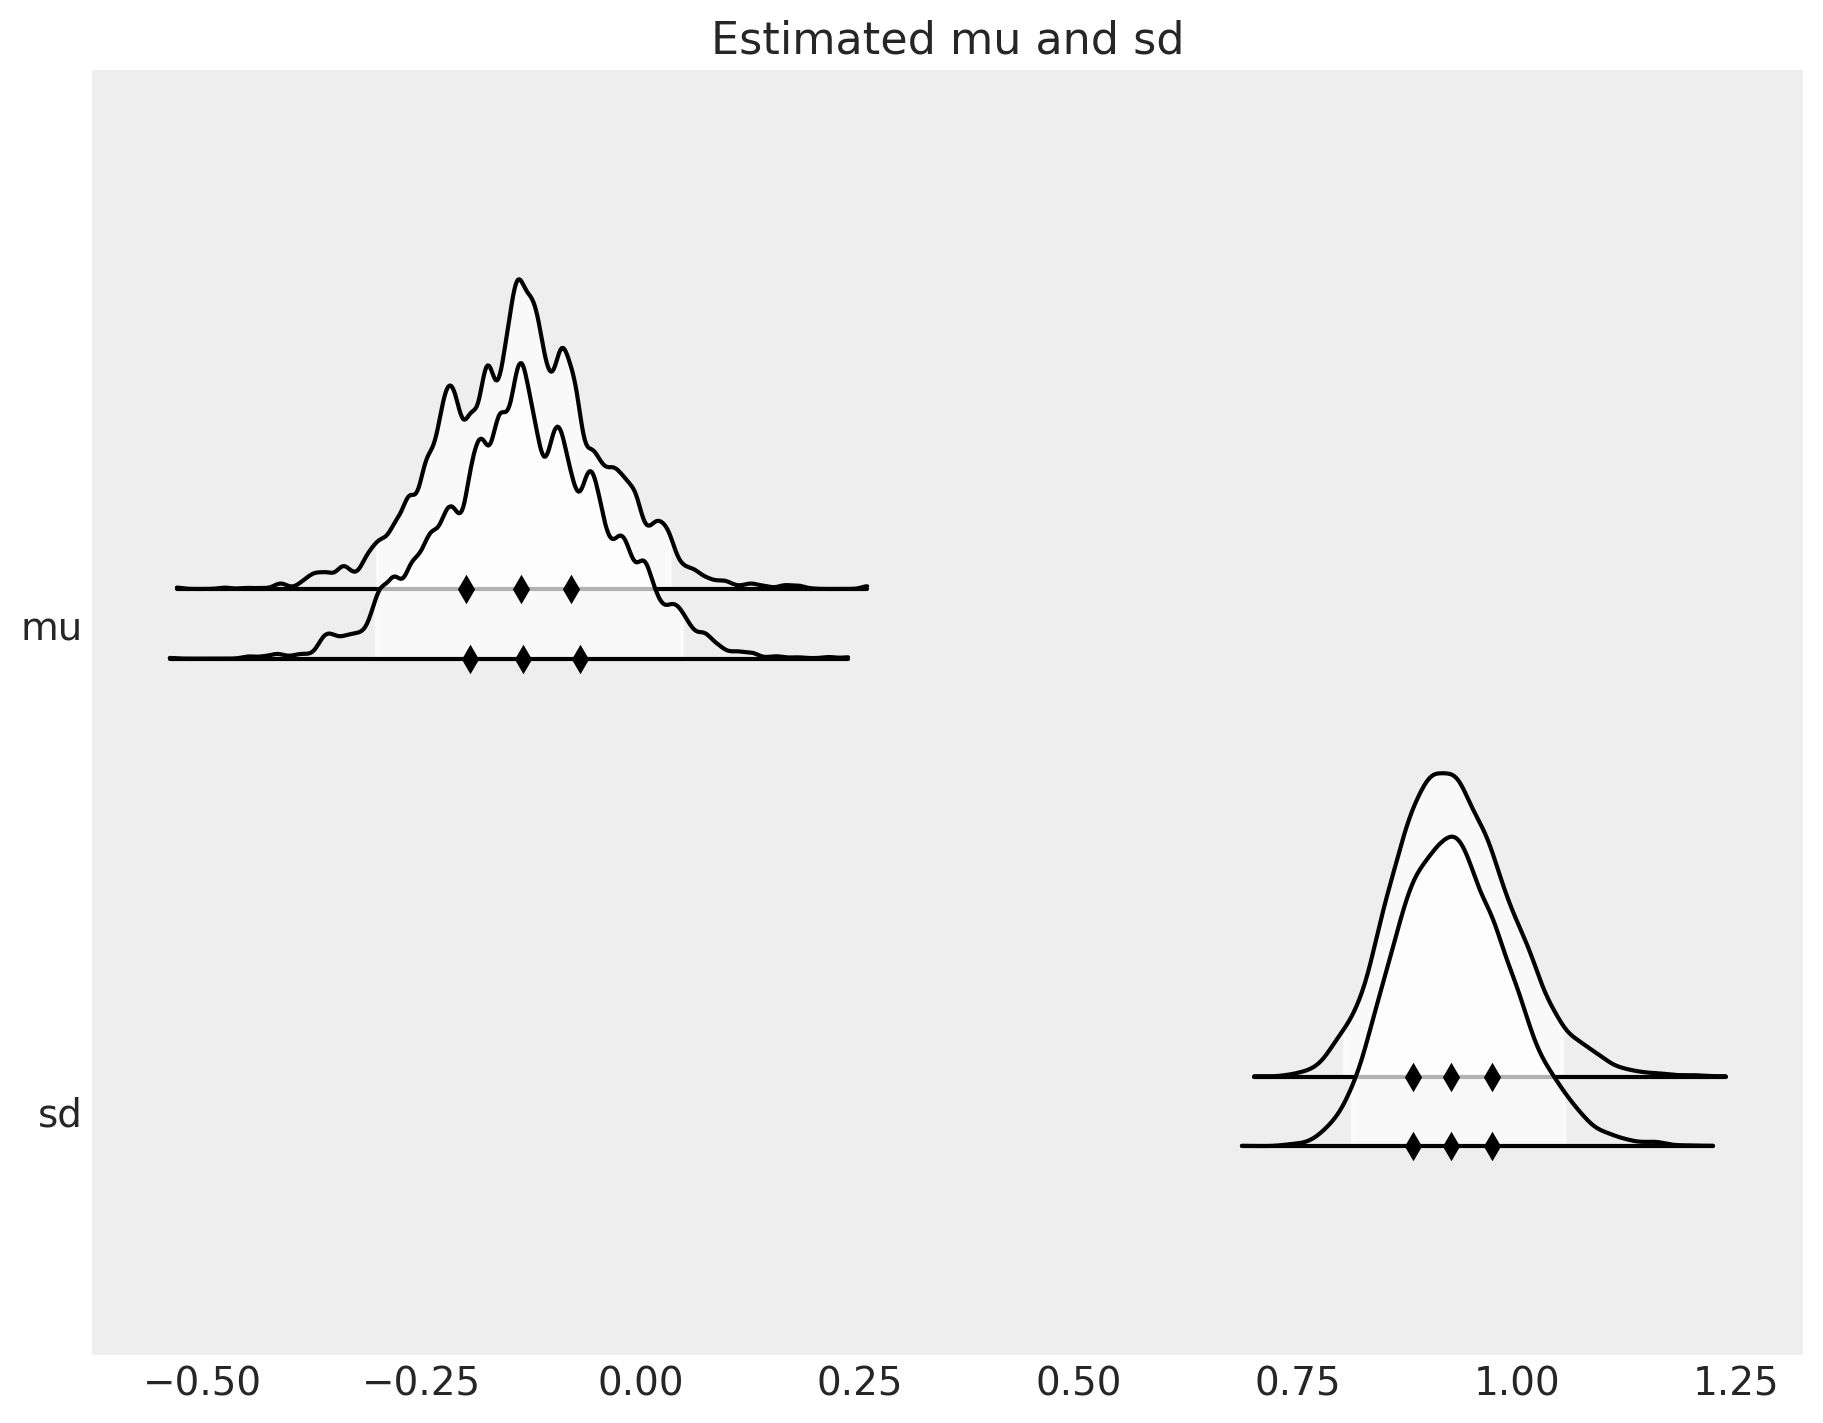

In [20]:
axes = az.plot_forest(idata,
                      kind='ridgeplot',
                      ridgeplot_truncate=False,
                      ridgeplot_quantiles=[.25, .5, .75],
                      ridgeplot_alpha=.7,
                      colors='white',
                      figsize=(9, 7))
axes[0].set_title('Estimated mu and sd')

* 似ているが別の可視化。
 * https://sites.google.com/site/doingbayesiandataanalysis/ この本の流儀による可視化だそうです（がよく知りません・・・）。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d43b81210>,
      dtype=object)

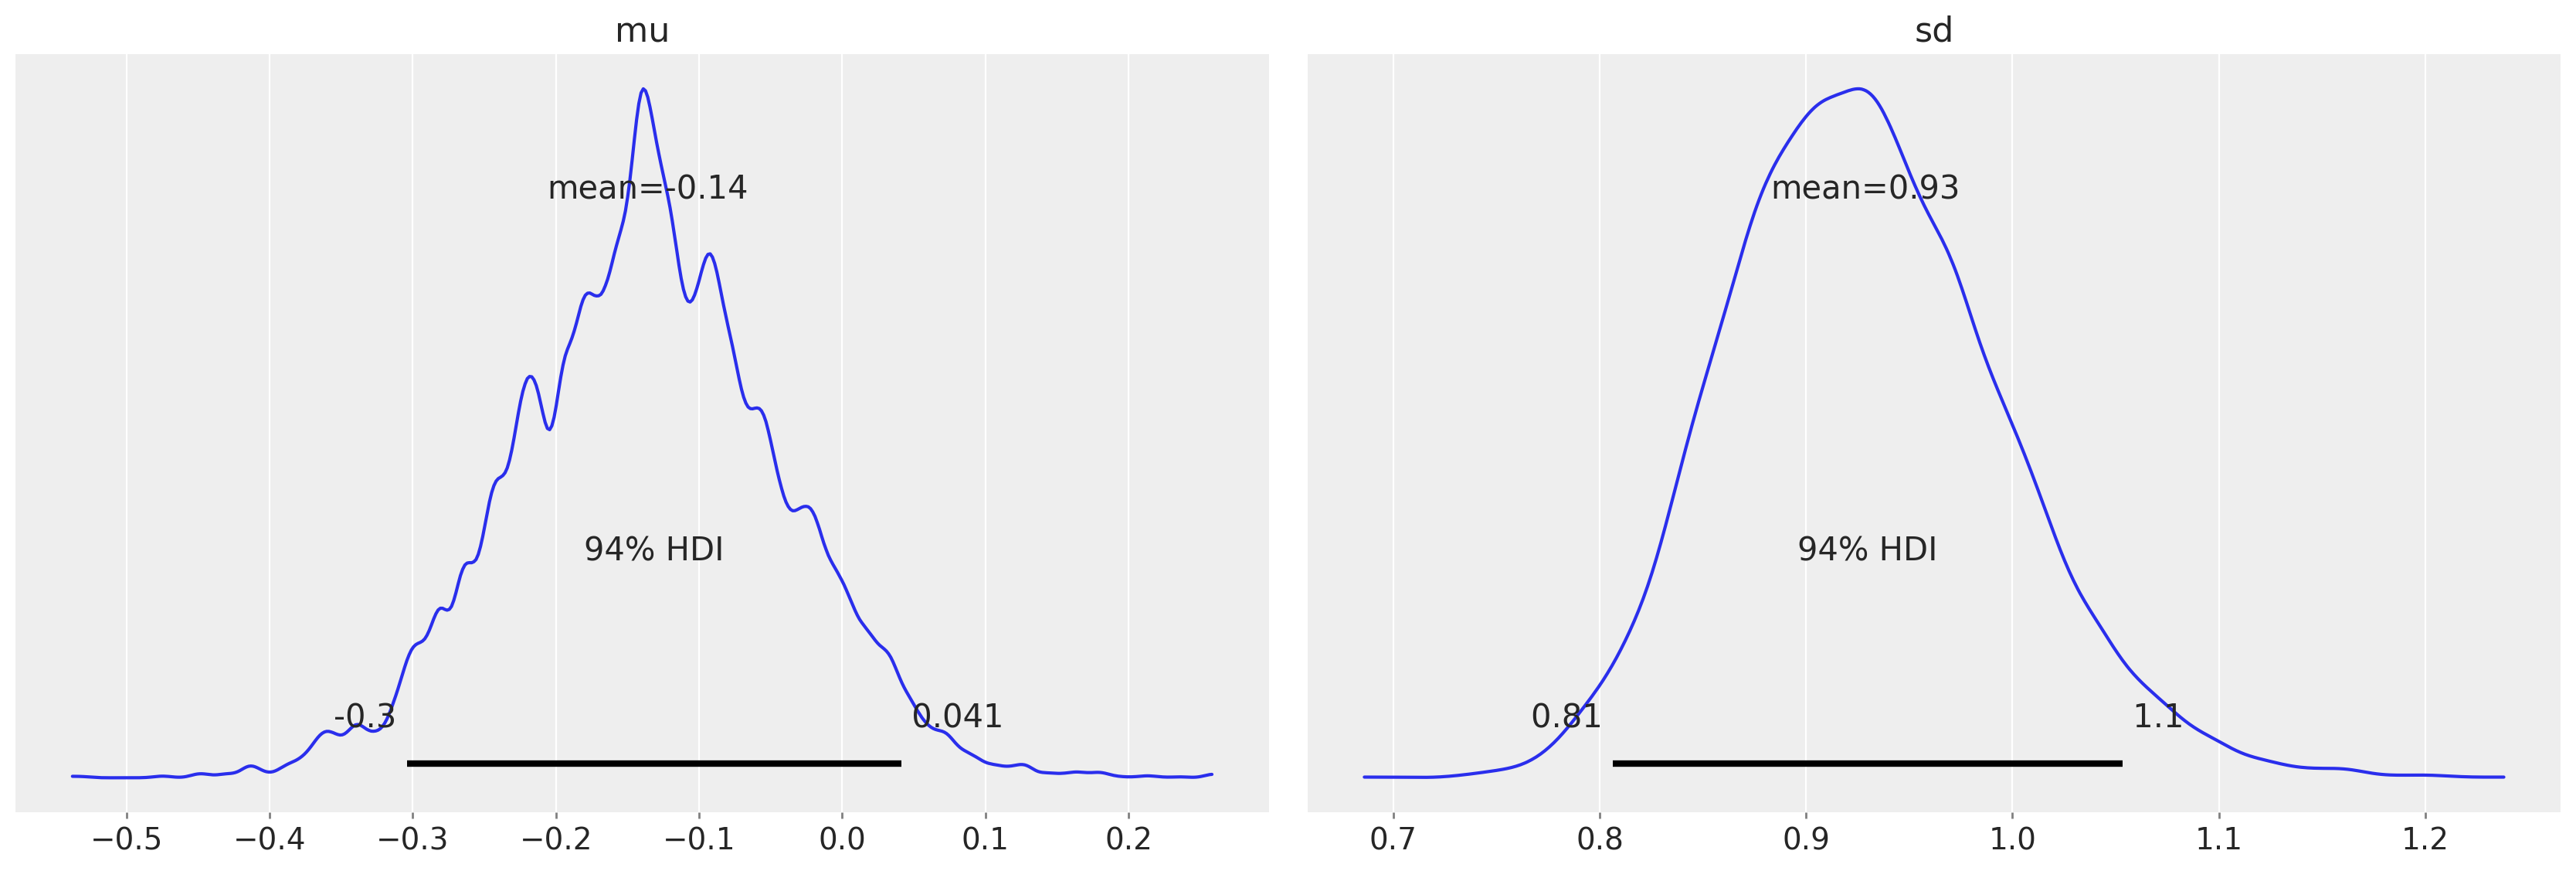

In [21]:
az.plot_posterior(idata)

* 同じモデルで、二つのパラメータとも、メトロポリス法を使う。

In [ ]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    step = pm.Metropolis()
    idata = pm.sample(10000, step=step, cores=len(SEED), return_inferencedata=True, random_seed=SEED)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f485354c7d0>,
      dtype=object)

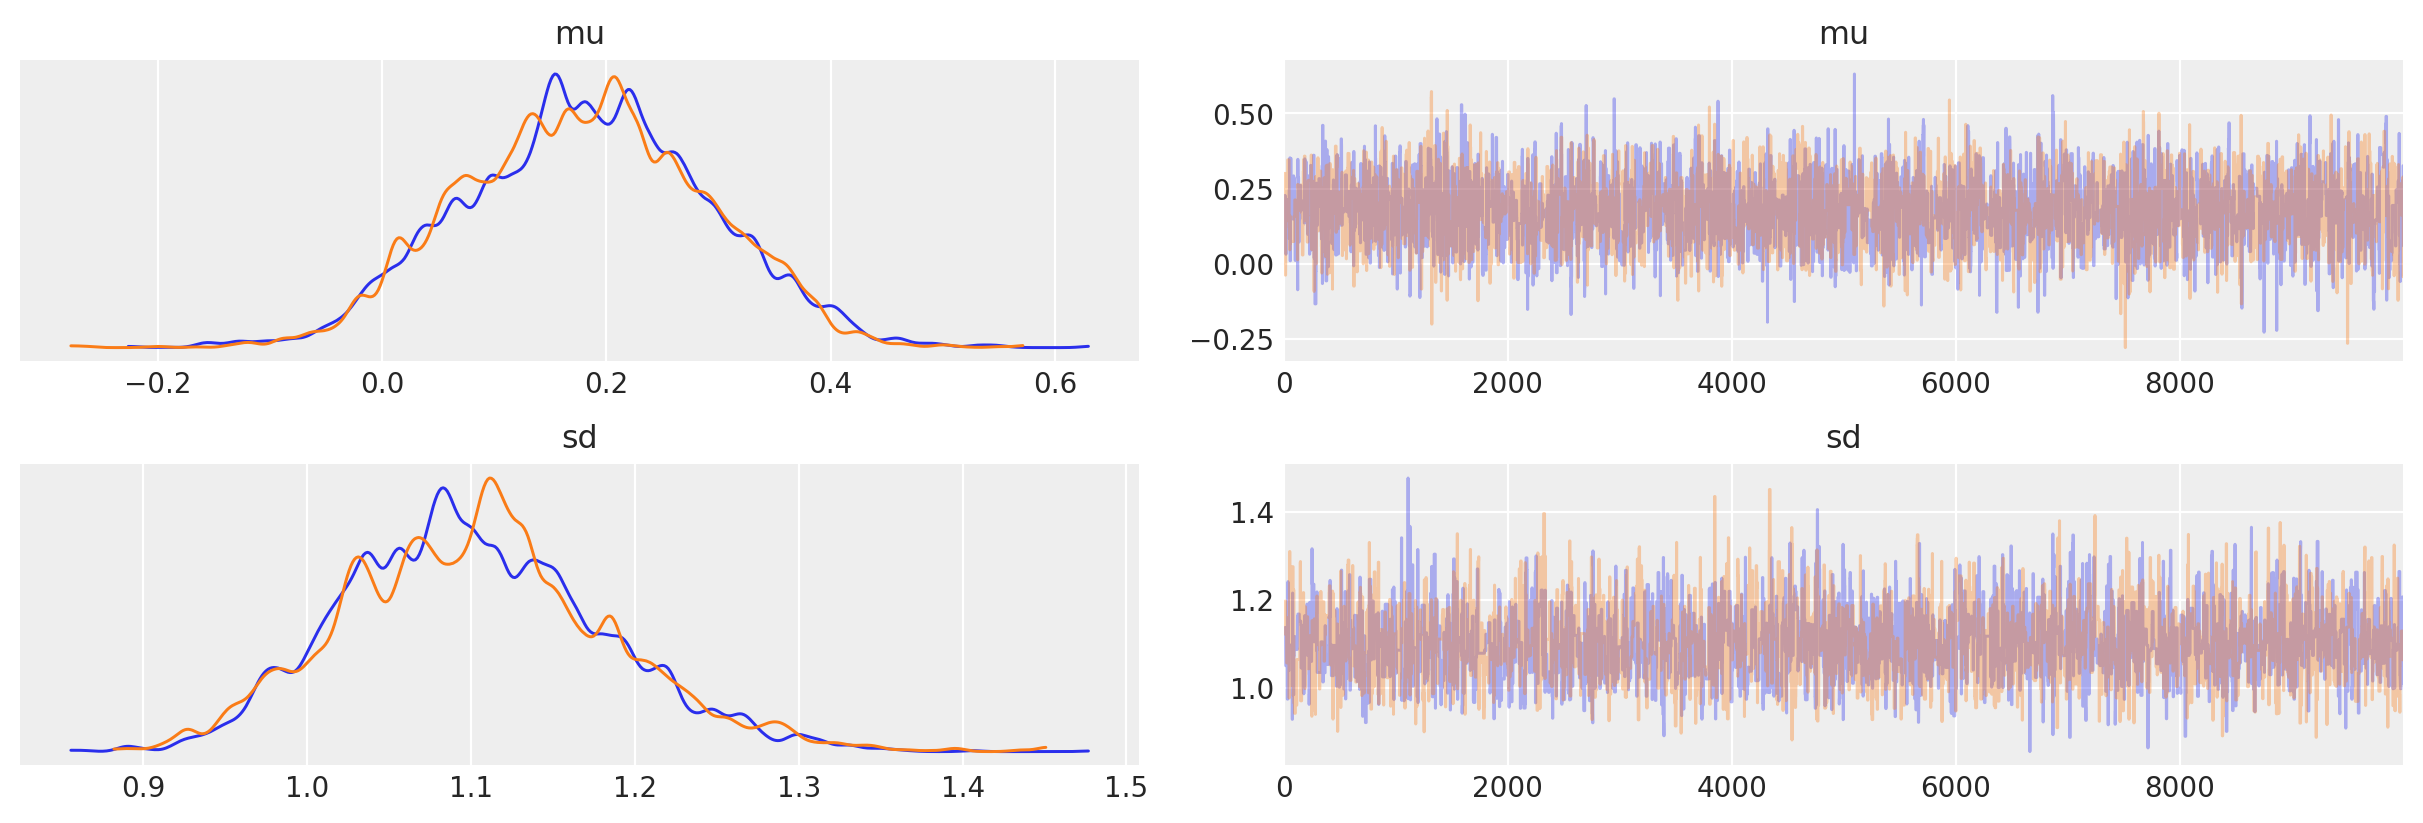

In [ ]:
az.plot_trace(idata)

### 3.2.4 energy transition distributionとmarginal energy distributionによる分析

* 同じモデルで、二つのパラメータとも、デフォルトのNo-U-Turn Sampler (NUTS)を使う。

In [ ]:
with pm.Model() as model:
    mu = pm.Normal("mu", mu=0, sigma=1)
    sd = pm.HalfNormal("sd", sigma=1)
    obs = pm.Normal("obs", mu=mu, sigma=sd, observed=np.random.randn(100))

    idata = pm.sample(10000, cores=len(SEED), return_inferencedata=True, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 21 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4876a62990>,
      dtype=object)

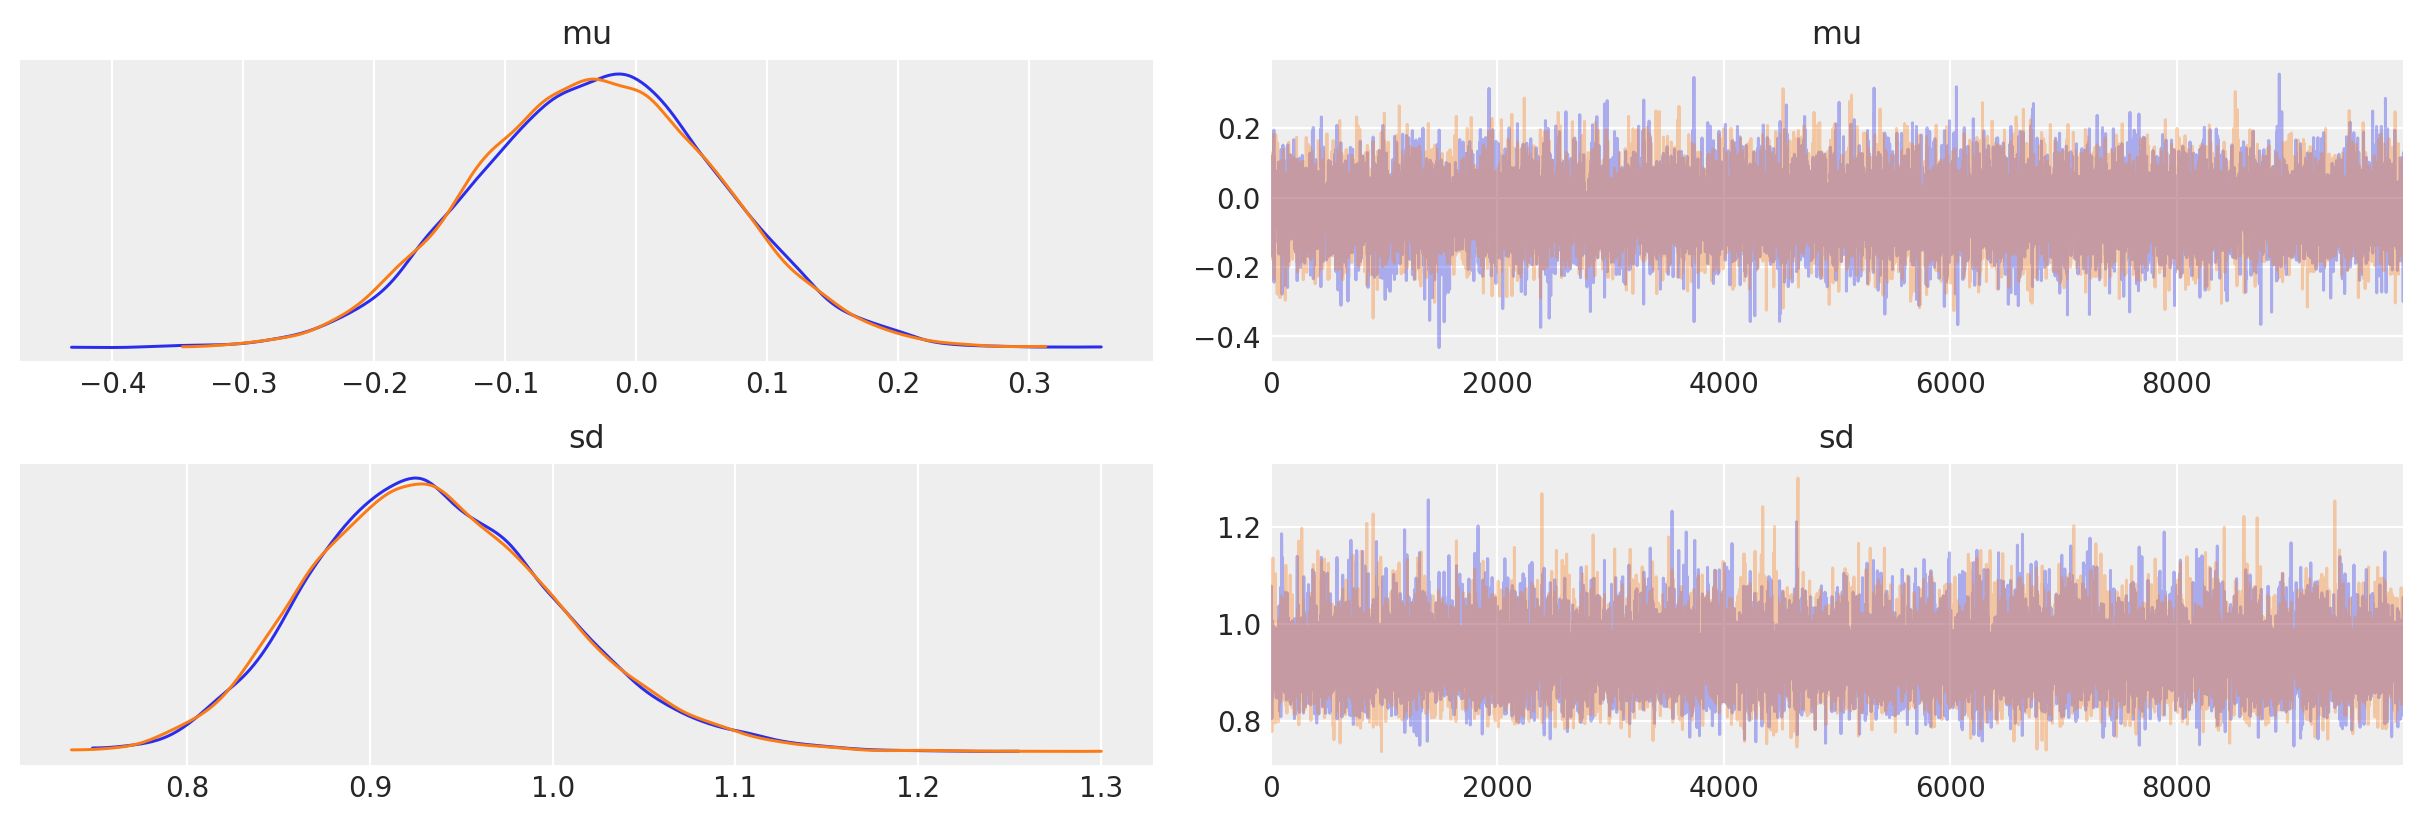

In [ ]:
az.plot_trace(idata)

* 事後分布がheavy tailedな分布だった場合、chainがその重たい裾野を十分に踏査していない可能性がある。
* arvizのplot_energyで、"Energy transition"の分布の幅のほうが、"Marginal Energy"の分布のそれより、相当狭い場合が要注意！
 * BFMI (Bayesian
fraction of missing information)については https://arxiv.org/abs/1604.00695 の3.1を参照。
 * https://arxiv.org/abs/1701.02434 も参照。

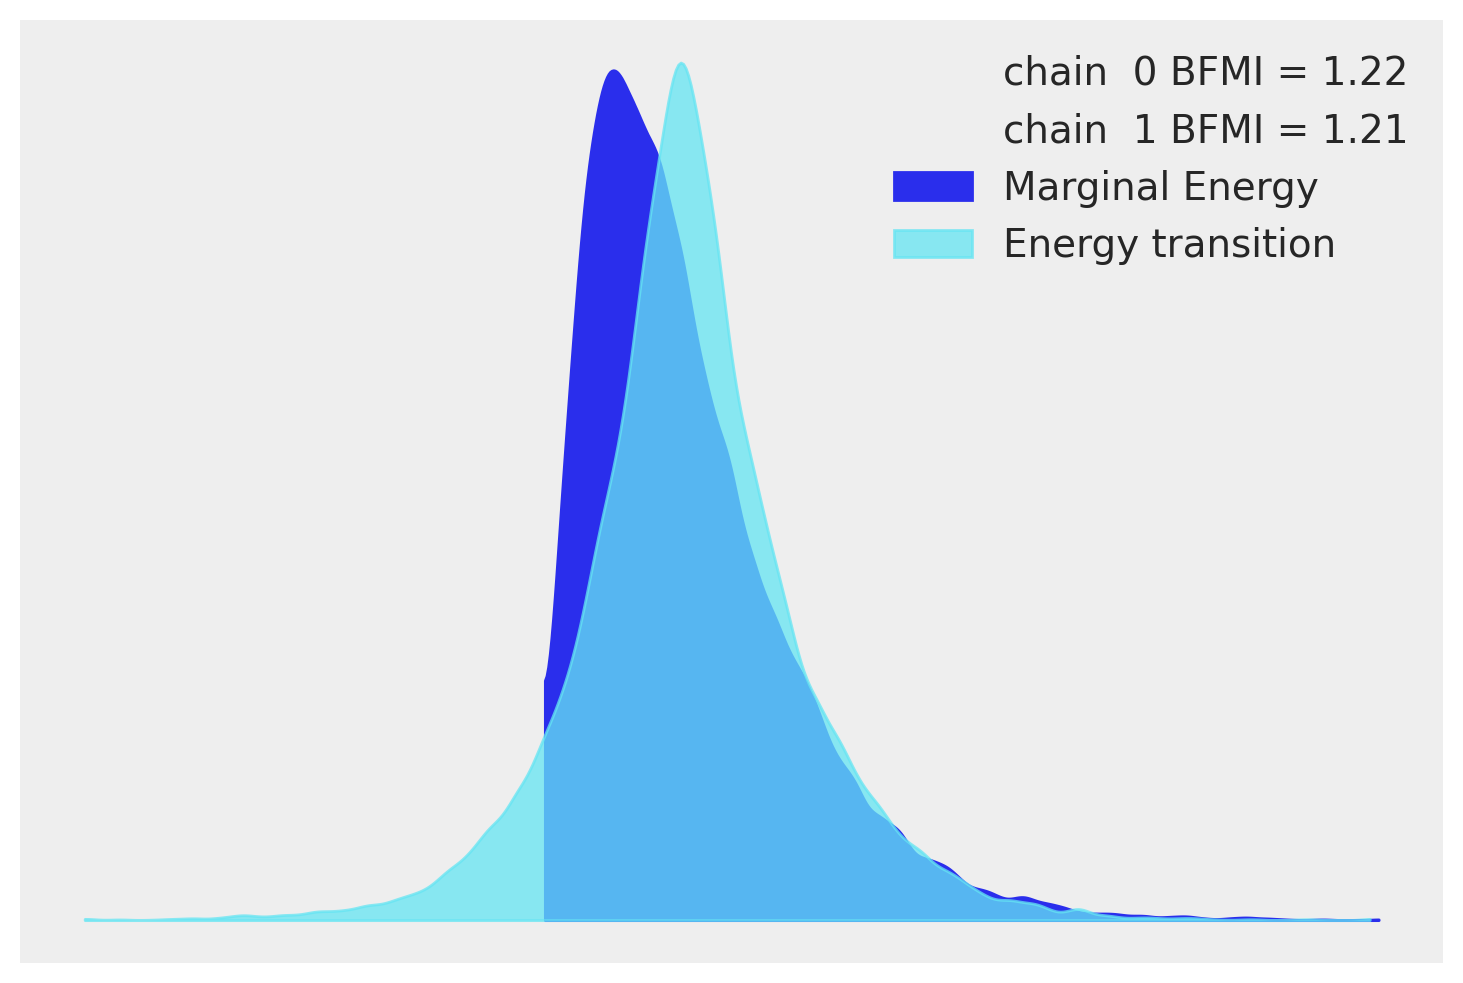

In [ ]:
az.plot_energy(idata)